# Dimension

While the majority of `momepy` functions require interaction of more `GeoDataFrames` or using spatial weights matrix, there are some which are calculated on single `GeoDataFrame` assessing the dimensions or shapes of features. This notebook illustrates this group on small part of Manhattan, New York.

In [1]:
import matplotlib.pyplot as plt
import momepy

We will again use `osmnx` to get the data for our example and after preprocessing of building layer will generate tessellation. You can show the code with the button on the right side.

In [2]:
import osmnx as ox

point = (40.731603, -73.977857)
dist = 1000
gdf = ox.features_from_point(point, dist=dist, tags={"building": True})
gdf_projected = ox.projection.project_gdf(gdf)
buildings = gdf_projected[
    gdf_projected.geom_type.isin(["Polygon", "MultiPolygon"])
].copy()

limit = momepy.buffered_limit(buildings)
tessellation = momepy.morphological_tessellation(buildings, clip=limit)

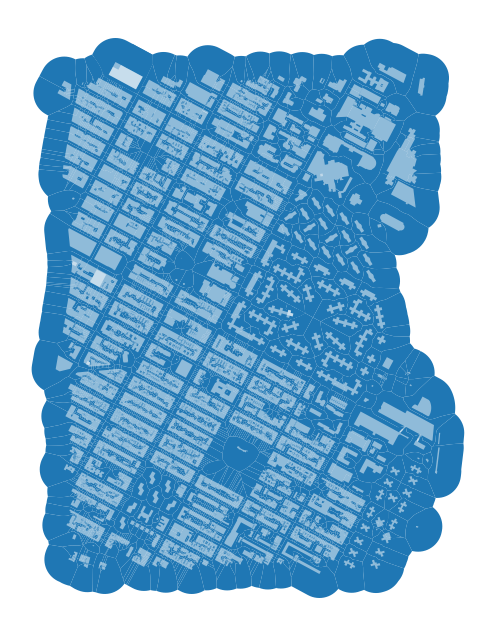

In [3]:
ax = tessellation.plot(figsize=(8, 8))
buildings.plot(ax=ax, color="white", alpha=0.5)
ax.set_axis_off()

We have some edge effect here as we are using the buffer as a limit for tessellation in the middle of urban fabric, but for this examples we can work with it anyway.

## Longest axis length

Some characters the same for more elements (buildings, tessellation, plots) like area, some makes sense only for a relevant ones. Longest axis length works for both, buildings and tessellation of our case study.

In [4]:
buildings["axis_length"] = momepy.longest_axis_length(buildings)

Given the `tessellation` is a `GeoSeries`, you need to convert it to a GeoDataFrame to assign values as a column.

In [5]:
tessellation["axis_length"] = momepy.longest_axis_length(tessellation)

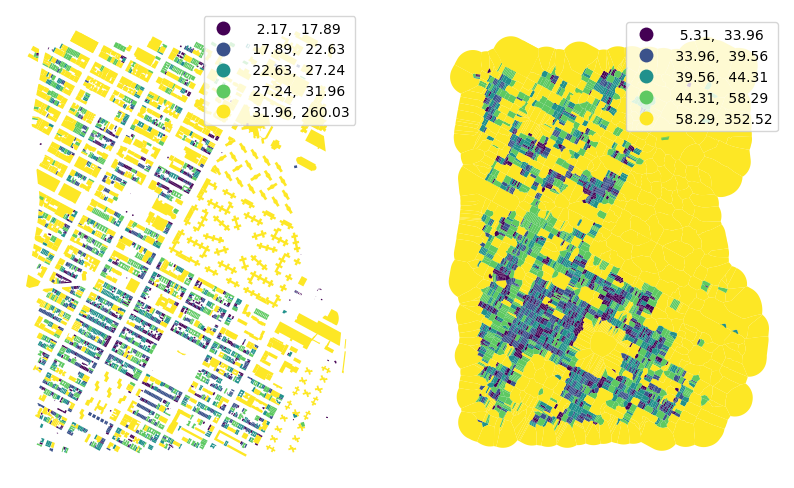

In [6]:
f, axs = plt.subplots(1, 2, figsize=(10, 10))
buildings.plot(ax=axs[0], column="axis_length", legend=True, scheme="quantiles")
axs[0].set_axis_off()
tessellation.plot(
    ax=axs[1], column="axis_length", legend=True, scheme="quantiles"
)
axs[1].set_axis_off()
plt.show()

## Height

We can often work with building heights (if we have the data). This part of New York has height data, only stored as strings, so we have to convert them to `floats` (or `int`) and fill `NaN` values with zero. Since some height attrbutes may be incorrectly defined in OSM, we use try/except to filter potential issues.

In [7]:
def clean_heights(x):
    try:
        return float(x)
    except ValueError:
        return 0


buildings["height"] = buildings["height"].fillna(0).apply(clean_heights)

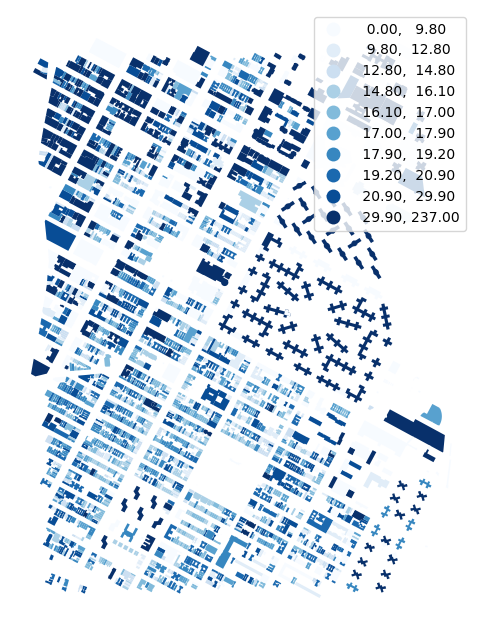

In [8]:
ax = buildings.plot(
    column="height",
    scheme="quantiles",
    k=10,
    legend=True,
    cmap="Blues",
    figsize=(8, 8),
)
ax.set_axis_off()

There are not many simple characters we can measure with height, but `volume` is possible. This requires an array reflecting the area and another reflecting the height.

In [9]:
buildings["volume"] = momepy.volume(
    area=buildings.area, height=buildings["height"]
)

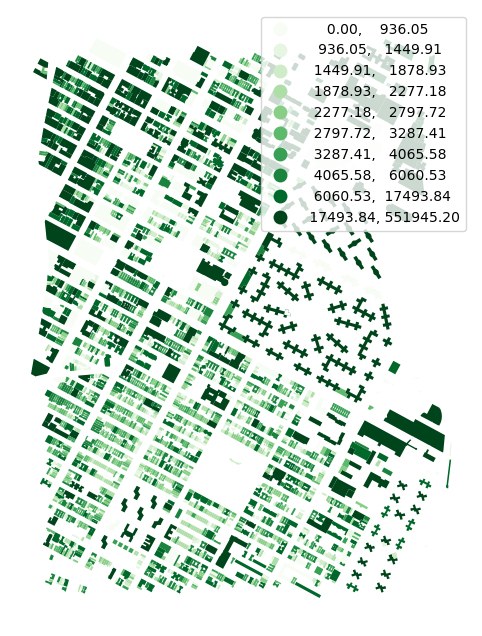

In [10]:
ax = buildings.plot(
    column="volume",
    legend=True,
    scheme="quantiles",
    k=10,
    cmap="Greens",
    figsize=(8, 8),
)
ax.set_axis_off()

Overview of all characters is available in [API](https://docs.momepy.org/en/latest/api.html), with additional examples of usage. Some characters make sense to calculate only in specific cases. Prime example is `courtyard_area` - there are many places where all buildings are courtyard-less, resulting in a `Series` full of zeros.